In [32]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import sys

sys.path.append("..") 
import d2lzh_pytorch as d2l

## 3.12.4 简洁实现

这里我们直接在构造优化器实例时通过`weight_decay`参数来指定权重衰减超参数。默认下，PyTorch会对权重和偏差同时衰减。我们可以分别对权重和偏差构造优化器实例，从而只对权重衰减。

In [33]:
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05


features = torch.randn((n_train + n_test, num_inputs))

labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), 
                       dtype=torch.float
                      )


train_features, test_features = features[:n_train, :], features[n_train:, :]

train_labels, test_labels = labels[:n_train], labels[n_train:]

In [34]:


dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

In [35]:
net, loss = d2l.linreg, d2l.squared_loss

In [36]:
n_train = 20
n_test = 100
num_inputs = 200


batch_size = 1
num_epochs = 100
lr = 0.003


def fit_and_plot_pytorch(wd):
    # 对权重参数衰减。权重名称一般是以weight结尾
    net = nn.Linear(num_inputs, 1)
    nn.init.normal_(net.weight, mean=0, std=1)
    nn.init.normal_(net.bias, mean=0, std=1)
    
    # 对权重参数衰减
    optimizer_w = torch.optim.SGD(params=[net.weight], 
                                  lr=lr, 
                                  weight_decay=wd
                                 )

    # 不对偏差参数衰减
    optimizer_b = torch.optim.SGD(params=[net.bias], 
                                  lr=lr
                                 )
    
    train_ls = []
    test_ls  = []
    
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            
            l.backward()
            
            # 对两个optimizer实例分别调用step函数，从而分别更新权重和偏差
            optimizer_w.step()
            optimizer_b.step()
            pass
        train_ls.append(loss(net(train_features), train_labels).mean().item())
        test_ls.append(loss(net(test_features), test_labels).mean().item())
        pass
    
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test']
                )

    print('L2 norm of w:', net.weight.data.norm().item())

与从零开始实现权重衰减的实验现象类似，使用权重衰减可以在一定程度上缓解过拟合问题。

L2 norm of w: 14.317864418029785


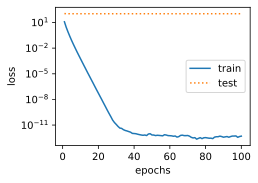

In [37]:
fit_and_plot_pytorch(0)

L2 norm of w: 0.05188516154885292


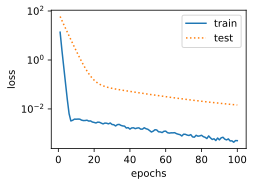

In [38]:
fit_and_plot_pytorch(3)

L2 norm of w: 0.03508464992046356


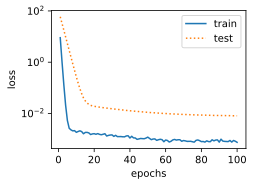

In [39]:
fit_and_plot_pytorch(5)

L2 norm of w: 0.0317525714635849


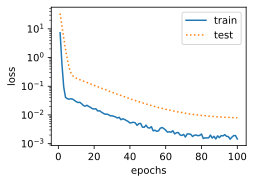

In [40]:
fit_and_plot_pytorch(8)

## 小结

* 正则化通过为模型损失函数添加惩罚项使学出的模型参数值较小，是应对过拟合的常用手段。
* 权重衰减等价于$L_2$范数正则化，通常会使学到的权重参数的元素较接近0。
* 权重衰减可以通过优化器中的`weight_decay`超参数来指定。
* 可以定义多个优化器实例对不同的模型参数使用不同的迭代方法。